<a href="https://colab.research.google.com/github/heokwon/OCR_Vehicle-registration-plate/blob/main/OCR_ImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install

In [1]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 4.6 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


## import

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

## Read Input Image


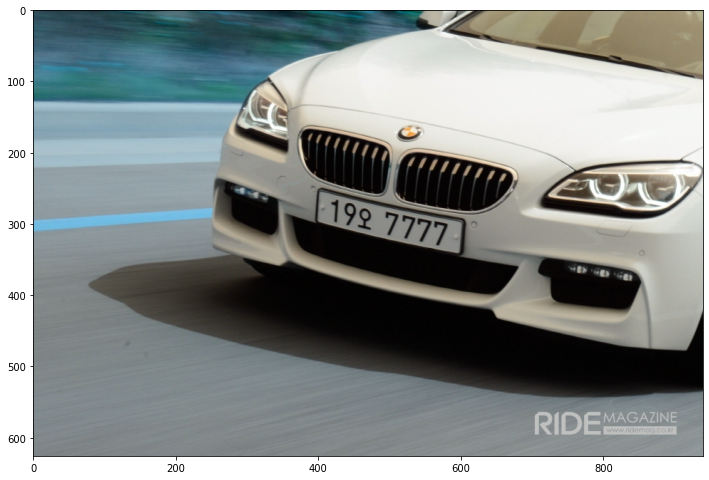

In [27]:
img_ori = cv2.imread('1.jpg')           # 이미지 로드
height, width, channel = img_ori.shape  # 1.jpg 의 shape을 변수로 지정(높이,너비,채널)
plt.figure(figsize=(12,10))             # 12x10 사이즈로 이미지 설정
plt.imshow(img_ori,cmap='gray')         

## Convert Image to Grayscale
* Image processing하기 쉽게

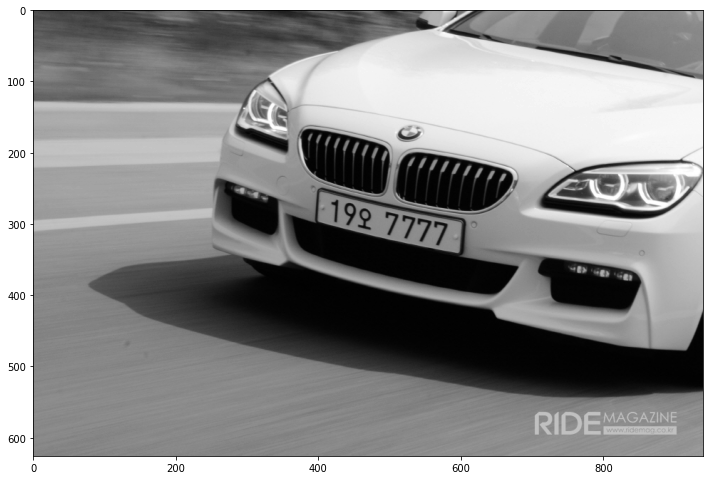

In [28]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV) # Grayscale대신 HSV로 바꿔서 v만 사용가능
                                                 # 사람 눈으로 봤을 때 거의 똑같음
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)  # Grayscale
plt.figure(figsize=(12,10))
plt.imshow(gray,cmap='gray')

## Adaptive Tresholding

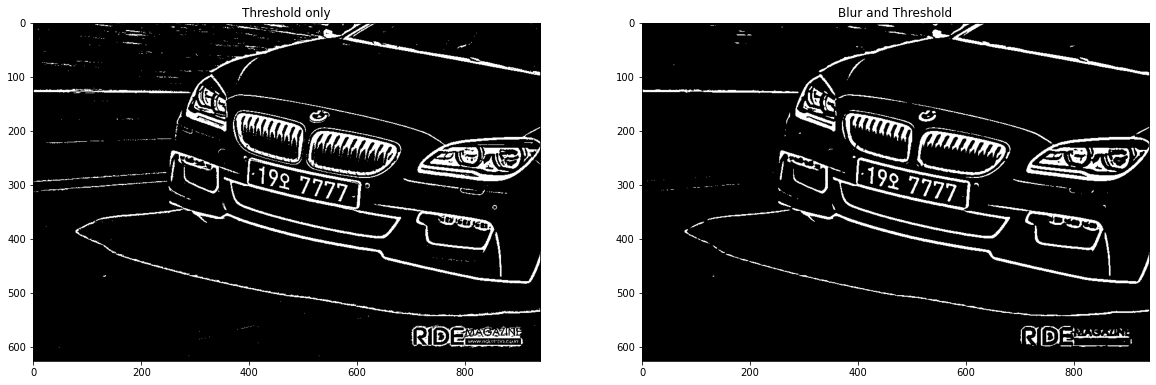

In [29]:
# threshold only
# 이미지의 threshold지정
# threshold 보다 낮으면 0
# threshold 보다 높으면 255로 고정
# adaptiveTresholding으로 이미지를 0과 255로 나눔 -> 컴퓨터가 번호판을 찾기 쉬워짐
img_thresh = cv2.adaptiveThreshold(gray,
                                  maxValue=255.0,
                                  adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  thresholdType=cv2.THRESH_BINARY_INV,
                                  blockSize=19,
                                  C=9)

img_blurred = cv2.GaussianBlur(gray,ksize=(5,5),sigmaX=0) # 이미지의 노이즈를 제거하기위해
img_blur_thresh = cv2.adaptiveThreshold(img_blurred,
                                       maxValue=255.0,
                                       adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       thresholdType=cv2.THRESH_BINARY_INV,
                                       blockSize=19,
                                       C=9)
# blur처리를 한 이미지와 그렇지 않은 이미지를 출력해보면
# blur처리를 한 이미지에서 노이즈가 제거된 것을 볼 수 있음
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Threshold only')
plt.imshow(img_thresh,cmap='gray')
plt.subplot(1,2,2)
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh,cmap='gray')

## FInd Contours

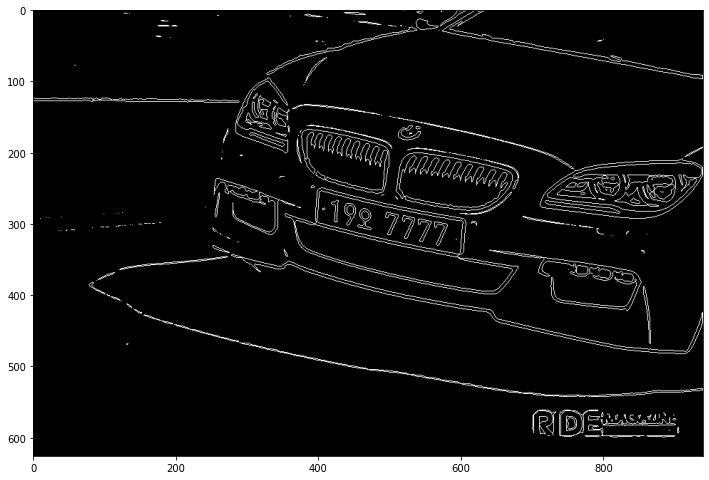

In [30]:
# contours = 윤곽선
contours, _ = cv2.findContours(img_blur_thresh,               # img_blur_thresh에서 윤곽선을 찾아줌
                                  mode=cv2.RETR_LIST,
                                  method=cv2.CHAIN_APPROX_SIMPLE)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255)) # 찾은 윤곽선들을 그려줌
                                                                                     # contourIdx = -1 : 전체 coutour을 다 그리겠다

plt.figure(figsize=(12,10))
plt.imshow(temp_result)

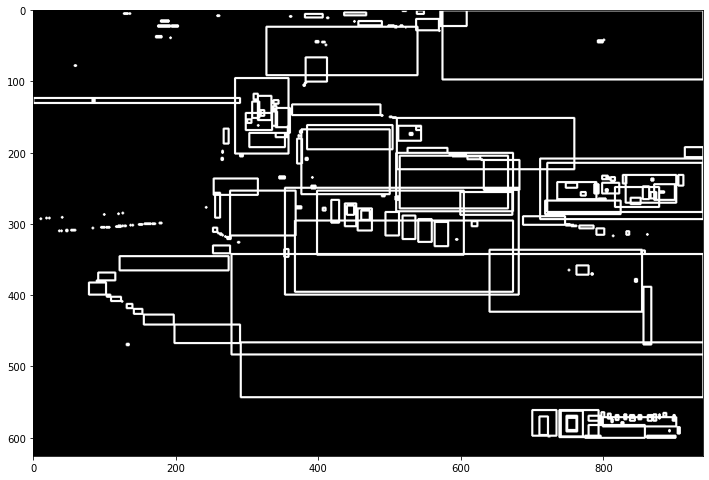

In [31]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict=[]
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour) # 윤곽선을 감싸는 사각형을 구함
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w,y+h), color=(255,255,255), thickness=2) # 이미지에 사각형을 그림

    # insert to dict
    contours_dict.append({'contour':contour,
                          'x':x,
                          'y':y,
                          'w':w,
                          'h':h,
                          'cx':x+(w/2),
                          'cy':y+(h/2)}) # cx, cy : contour을 감싸는 사각형의 중심좌표(bbox의 중심좌표))

plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')               

## Select Candidates by Char Size

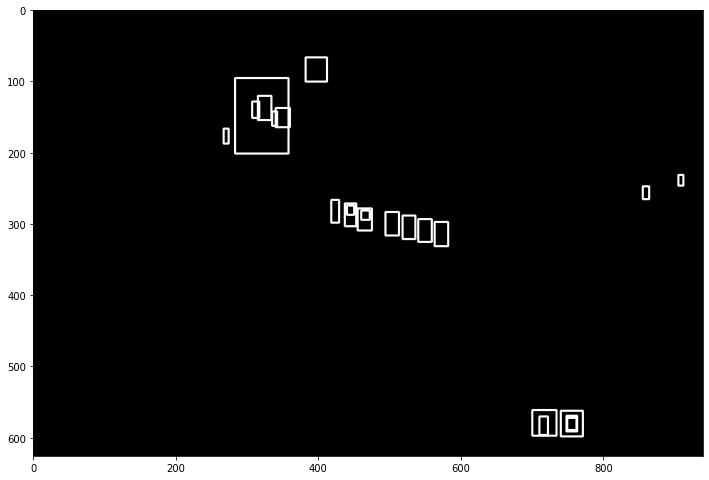

In [32]:
# 번호판 글자의 크기를 가정
MIN_AREA = 80                      # bounding rect의 최소 넓이
MIN_WIDTH, MIN_HEIGHT = 2, 8       # 최소 너비와 높이
MIN_RATIO, MAX_RATIO = 0.25, 1.0   # 가로대비 세로 비율의 min, max값

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w']*d['h']
    ratio = d['w']/d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt              # 각 윤곽선의 idx값을 매겨놓고,
        cnt += 1                    # 나중에 조건에 맞는 윤곽선들의 idx만 따로 빼냄
        possible_contours.append(d)

# Visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)

plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')

## Select Candidates by Arrangement of Contours
possible_contours의 정렬방식을 보고 번호판 후보들을 추려냄

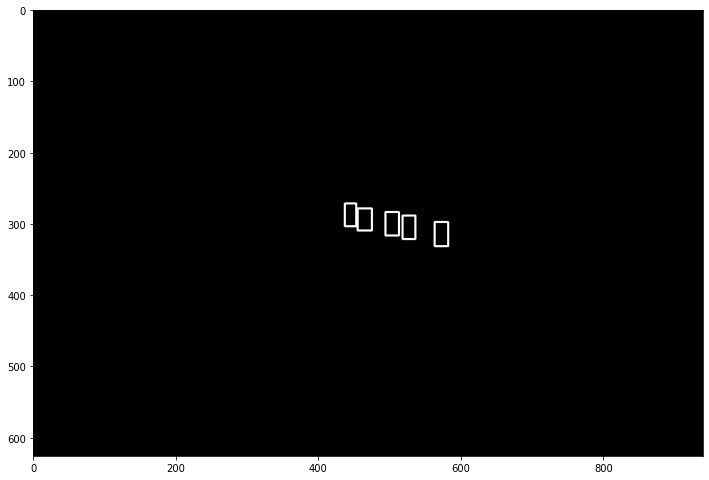

In [36]:
MAX_DIAG_MULTIPLYER = 5 # contour와 contour 사이의 길이를 제한,첫 번째 contour의 대각선 길이의 5배 안에 있어야 함
MAX_ANGLE_DIFF = 12.0 # 첫번째 contour와 두번째 contour의 중심을 이어 그려지는 직각삼각형에서 세타의 최대값
MAX_AREA_DIFF = 0.5   # 면적차이
MAX_WIDTH_DIFF = 0.8  # 너비차이
MAX_HEIGHT_DIFF = 0.2 # 높이차이
MIN_N_MATCHED = 3     # 위 조건을 만족하는 애들이 최소 3개 이상이어야 함

# 재귀함수로 번호판 후보군을 찾기 위해 함수화
def find_chars(contour_list):
    matched_result_idx=[] # 최종적으로 남는 결과물을 저장

    for d1 in contour_list: # contour d1과 contour d2를 비교
        matched_contours_idx=[]
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w']**2+d1['h']**2)

            distance = np.linalg.norm(np.array([d1['cx'],d1['cy']])-np.array([d2['cx'],d2['cy']]))
            if dx == 0: angle_diff = 90 # 에러방지를 위해 예외처리
            else: angle_diff = np.degrees(np.arctan(dy/dx)) # 아크탄젠트 값을 구함(라디안) > 라디안 값은 degree로 변경
            area_diff = abs(d1['w']*d1['h']-d2['w']*d2['h'])/(d1['w']*d1['h']) # 면적의 비율
            width_diff = abs(d1['w']-d2['w'])/d1['w'] # 너비의 비율
            height_diff = abs(d1['h']-d2['h'])/d1['h'] # 높이의 비율

            if distance < diagonal_length1*MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx']) # 위 설정한 파라미터 기준에 맞는 애들만
                                                       # 빈 리스트에 append
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED: continue # 위 설정한 파라미터보다 작으면 제외

        matched_result_idx.append(matched_contours_idx) # 최종 후보군

        unmatched_contour_idx=[] # 최종 후보군이 아닌 애들끼리 비교
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx: unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx) # np.take(a,idx) : a에서 idx와 같은 인덱스의 값만 추출

        # recursive
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list: matched_result_idx.append(idx)
        break
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result=[]
for idx_list in result_idx: matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')